<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

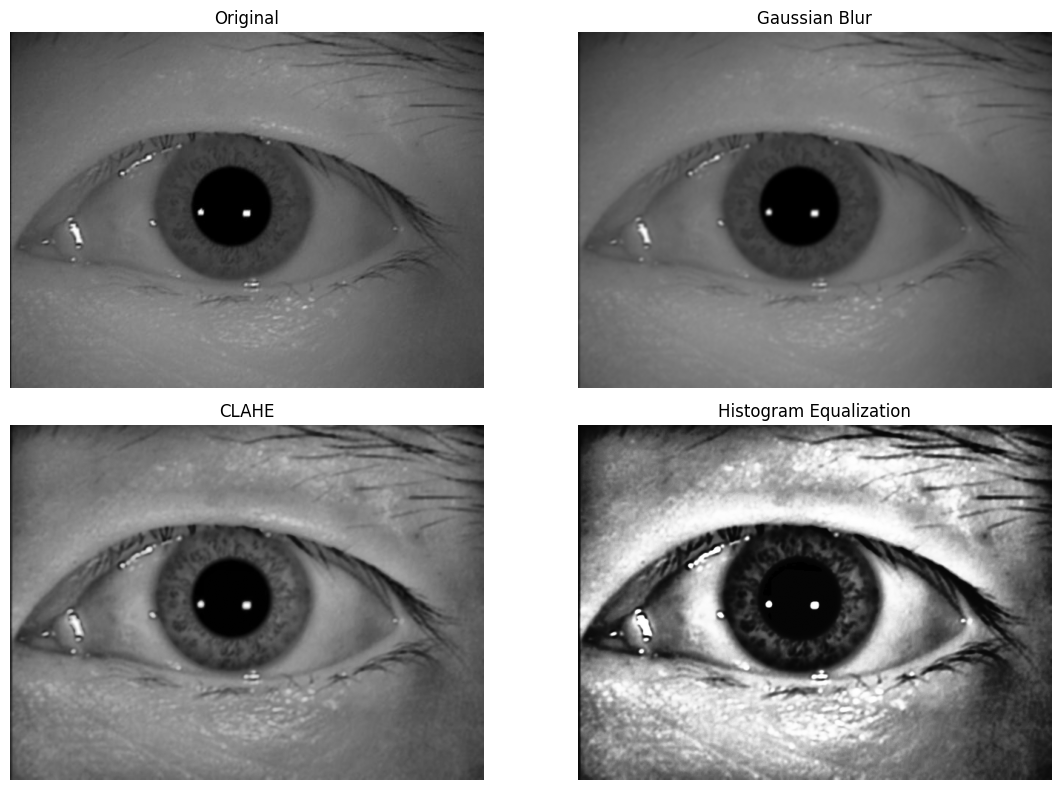

+------------------------+---------------+---------------+--------+-----------+---------------+
| Stage                  | Parameter 1   | Parameter 2   |   Mean |   Std Dev |   Pixel Count |
+========================+===============+===============+========+===========+===============+
| Original               | -             | -             |  98.21 |     29.98 |        307200 |
+------------------------+---------------+---------------+--------+-----------+---------------+
| Gaussian Blur          | Kernel=(5, 5) | Sigma=1.5     |  98.23 |     29.56 |        307200 |
+------------------------+---------------+---------------+--------+-----------+---------------+
| CLAHE                  | Grid=(8,8)    | Clip=2.0      | 111.59 |     34.83 |        307200 |
+------------------------+---------------+---------------+--------+-----------+---------------+
| Histogram Equalization | -             | -             | 128.42 |     73.94 |        307200 |
+------------------------+--------------

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load image
image = cv2.imread("/content/S6000S00.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found")

# Step 1: Gaussian Blur
kernel_size = (5, 5)
sigma = 1.5
gaussian_blur = cv2.GaussianBlur(image, kernel_size, sigma)

# Step 2: CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_result = clahe.apply(gaussian_blur)

# Step 3: Histogram Equalization
he_result = cv2.equalizeHist(clahe_result)

# Step 4: Save the final preprocessed image
cv2.imwrite("/content/preprocessed_image.jpg", he_result)

# Step 5: Display images
images = [image, gaussian_blur, clahe_result, he_result]
titles = ["Original", "Gaussian Blur", "CLAHE", "Histogram Equalization"]
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 6: Tabulate metrics
def compute_stats(img):
    return float(np.mean(img)), float(np.std(img)), int(np.prod(img.shape))

stats = [
    compute_stats(image),
    compute_stats(gaussian_blur),
    compute_stats(clahe_result),
    compute_stats(he_result)
]

table = [
    ["Original", "-", "-", f"{stats[0][0]:.2f}", f"{stats[0][1]:.2f}", stats[0][2]],
    ["Gaussian Blur", f"Kernel={kernel_size}", f"Sigma={sigma}", f"{stats[1][0]:.2f}", f"{stats[1][1]:.2f}", stats[1][2]],
    ["CLAHE", "Grid=(8,8)", "Clip=2.0", f"{stats[2][0]:.2f}", f"{stats[2][1]:.2f}", stats[2][2]],
    ["Histogram Equalization", "-", "-", f"{stats[3][0]:.2f}", f"{stats[3][1]:.2f}", stats[3][2]]
]

headers = ["Stage", "Parameter 1", "Parameter 2", "Mean", "Std Dev", "Pixel Count"]
print(tabulate(table, headers=headers, tablefmt="grid"))


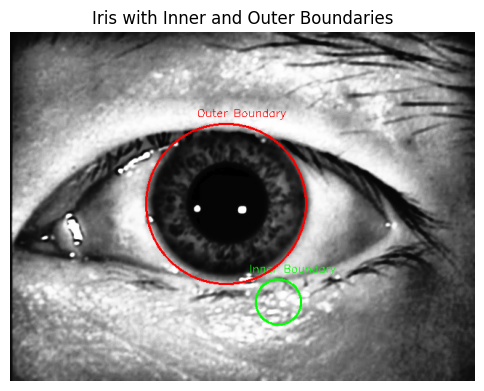

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('/content/preprocessed_image.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect inner circle (pupil)
inner_circles = cv2.HoughCircles(
    blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
    param1=100, param2=30, minRadius=20, maxRadius=50
)

# Detect outer circle (iris)
outer_circles = cv2.HoughCircles(
    blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
    param1=100, param2=60, minRadius=60, maxRadius=120
)

# Draw the results
output = image.copy()

if inner_circles is not None:
    inner_circles = np.uint16(np.around(inner_circles))
    for (x, y, r) in inner_circles[0, :1]:  # Take only the most prominent one
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        cv2.putText(output, 'Inner Boundary', (x - 40, y - r - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

if outer_circles is not None:
    outer_circles = np.uint16(np.around(outer_circles))
    for (x, y, r) in outer_circles[0, :1]:  # Take only the most prominent one
        cv2.circle(output, (x, y), r, (0, 0, 255), 2)
        cv2.putText(output, 'Outer Boundary', (x - 40, y - r - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Display result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Iris with Inner and Outer Boundaries")
plt.axis('off')
plt.show()

cv2.imwrite('/content/iris_segmented_with_boundaries.jpg', output)


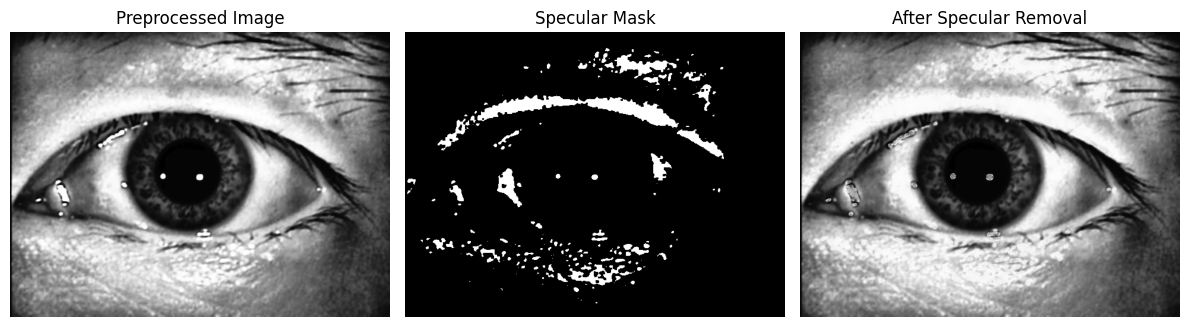

+------------------------+------------------+-----------+-------------------+
| Stage                  |   Mean Intensity |   Std Dev |   Non-zero Pixels |
+========================+==================+===========+===================+
| Preprocessed Image     |           128.42 |     73.95 |            306674 |
+------------------------+------------------+-----------+-------------------+
| Specular Mask          |            15.76 |     61.4  |             18985 |
+------------------------+------------------+-----------+-------------------+
| After Specular Removal |           127.29 |     72.4  |            306674 |
+------------------------+------------------+-----------+-------------------+


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load preprocessed grayscale image
image = cv2.imread("/content/preprocessed_image.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Preprocessed image not found")

# Step 1: Threshold to detect specular reflections
threshold_value = 240
_, reflection_mask = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

# Step 2: Morphological cleaning (close small holes)
kernel = np.ones((3, 3), np.uint8)
reflection_mask_cleaned = cv2.morphologyEx(reflection_mask, cv2.MORPH_CLOSE, kernel)

# Step 3: Inpaint the specular regions
inpainted_image = cv2.inpaint(image, reflection_mask_cleaned, 3, cv2.INPAINT_TELEA)

# Step 4: Save output
cv2.imwrite("/content/image_without_specular.jpg", inpainted_image)

# Step 5: Display results
images = [image, reflection_mask_cleaned, inpainted_image]
titles = ["Preprocessed Image", "Specular Mask", "After Specular Removal"]
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 6: Tabulate statistics
def get_stats(img):
    return float(np.mean(img)), float(np.std(img)), int(np.sum(img > 0))

stats = [get_stats(im) for im in images]
table = [
    [titles[i], f"{stats[i][0]:.2f}", f"{stats[i][1]:.2f}", stats[i][2]]
    for i in range(3)
]
headers = ["Stage", "Mean Intensity", "Std Dev", "Non-zero Pixels"]
print(tabulate(table, headers=headers, tablefmt="grid"))


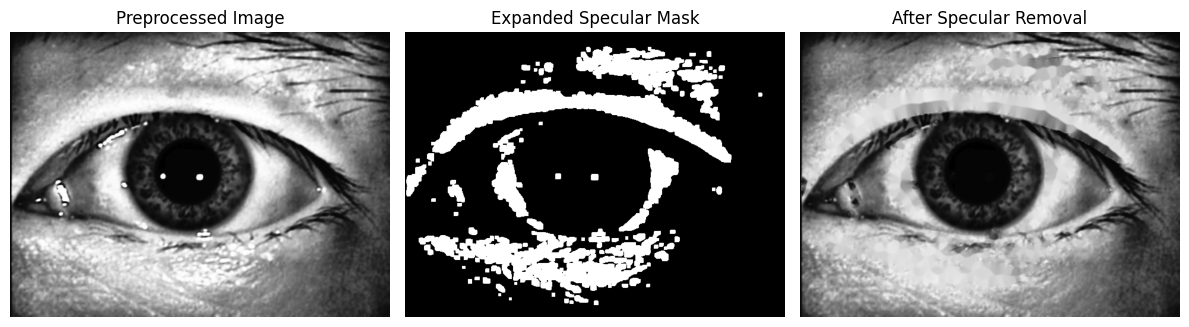

+------------------------+------------------+-----------+-------------------+
| Stage                  |   Mean Intensity |   Std Dev |   Non-zero Pixels |
+========================+==================+===========+===================+
| Preprocessed Image     |           128.42 |     73.95 |            306674 |
+------------------------+------------------+-----------+-------------------+
| Expanded Specular Mask |            53.3  |    103.69 |             64216 |
+------------------------+------------------+-----------+-------------------+
| After Specular Removal |           119.19 |     64.3  |            306674 |
+------------------------+------------------+-----------+-------------------+


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load preprocessed grayscale image
image = cv2.imread("/content/preprocessed_image.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Preprocessed image not found")

# Step 1: Apply Gaussian blur to merge close highlights
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Lowered threshold to detect broader specular reflections
threshold_value = 220
_, reflection_mask = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

# Step 3: Morphological dilation to expand specular regions
kernel = np.ones((5, 5), np.uint8)
reflection_mask_dilated = cv2.dilate(reflection_mask, kernel, iterations=1)

# Step 4: Inpaint the specular regions
inpainted_image = cv2.inpaint(image, reflection_mask_dilated, 3, cv2.INPAINT_TELEA)

# Step 5: Save output
cv2.imwrite("/content/image_without_specular1.jpg", inpainted_image)

# Step 6: Display results
images = [image, reflection_mask_dilated, inpainted_image]
titles = ["Preprocessed Image", "Expanded Specular Mask", "After Specular Removal"]
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 7: Tabulate statistics
def get_stats(img):
    return float(np.mean(img)), float(np.std(img)), int(np.sum(img > 0))

stats = [get_stats(im) for im in images]
table = [
    [titles[i], f"{stats[i][0]:.2f}", f"{stats[i][1]:.2f}", stats[i][2]]
    for i in range(3)
]
headers = ["Stage", "Mean Intensity", "Std Dev", "Non-zero Pixels"]
print(tabulate(table, headers=headers, tablefmt="grid"))


Connected Components Found: 14
Component 1: Area = 5
Component 2: Area = 5
Component 3: Area = 5
Component 4: Area = 5
Component 5: Area = 5
Component 6: Area = 5
Component 7: Area = 5
Component 8: Area = 5
Component 9: Area = 5
Component 10: Area = 5
Component 11: Area = 5
Component 12: Area = 5
Component 13: Area = 5
Component 14: Area = 5


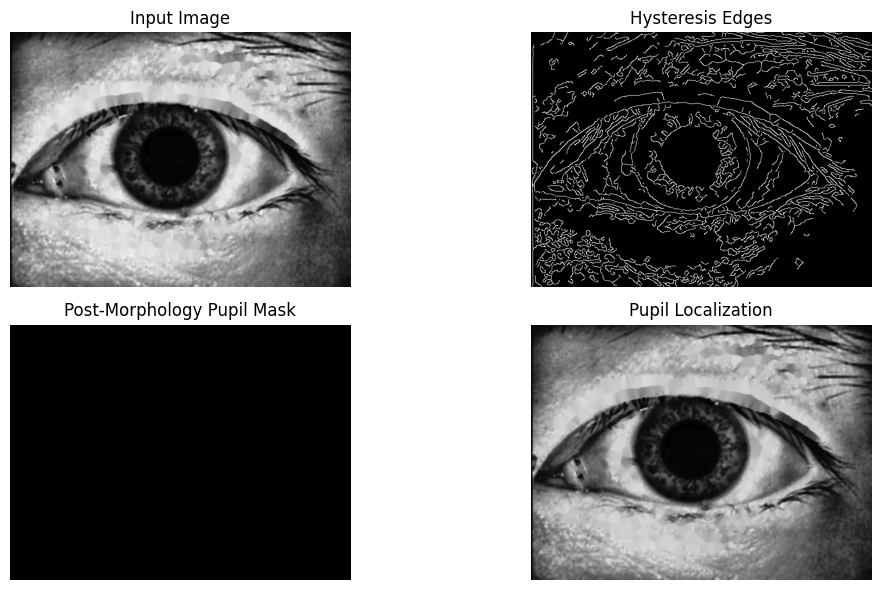

+----------------------------+------------------+-----------+-------------------+
| Stage                      |   Mean Intensity |   Std Dev |   Non-zero Pixels |
+============================+==================+===========+===================+
| Input Image                |           119.19 |     64.3  |            306698 |
+----------------------------+------------------+-----------+-------------------+
| Hysteresis Edges           |            22.22 |     71.91 |             26763 |
+----------------------------+------------------+-----------+-------------------+
| Post-Morphology Pupil Mask |             0    |      0    |                 0 |
+----------------------------+------------------+-----------+-------------------+
| Pupil Localization         |           119.19 |     64.3  |            306698 |
+----------------------------+------------------+-----------+-------------------+


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load the grayscale image
input_image = cv2.imread("/content/image_without_specular1.jpg", cv2.IMREAD_GRAYSCALE)
if input_image is None:
    raise FileNotFoundError("Image not found")

# Step 1: Pre-smoothing before edge detection
blurred = cv2.GaussianBlur(input_image, (5, 5), 1.5)

# Step 2: Hysteresis Edge Detection
T_low, T_high = 30, 80
edges = cv2.Canny(blurred, T_low, T_high)

# Step 3: Morphological Operations - Opening (Erode + Dilate)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
eroded = cv2.erode(edges, kernel, iterations=1)
dilated = cv2.dilate(eroded, kernel, iterations=1)  # Add dilation to regain structure

# Step 4: Connected Component Analysis (tuned area threshold)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated, connectivity=8)
pupil_mask = np.zeros_like(dilated)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 10 < area < 10000:  # filter small & very large noise
        pupil_mask[labels == i] = 255

# Debugging connected components
print("Connected Components Found:", num_labels - 1)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    print(f"Component {i}: Area = {area}")


# Step 5: Pupil Localization via Hough Circles
circles = cv2.HoughCircles(pupil_mask, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                           param1=50, param2=12, minRadius=10, maxRadius=60)

pupil_localized = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :1]:
        x, y, r = circle
        cv2.circle(pupil_localized, (x, y), r, (0, 255, 0), 2)
        cv2.circle(pupil_localized, (x, y), 2, (0, 0, 255), 3)

# Step 6: Visualization
titles = ["Input Image", "Hysteresis Edges", "Post-Morphology Pupil Mask", "Pupil Localization"]
images = [input_image, edges, pupil_mask, pupil_localized]

plt.figure(figsize=(12, 6))
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 7: Quantitative Table
def compute_stats(image):
    gray = image if image.ndim == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return [f"{np.mean(gray):.2f}", f"{np.std(gray):.2f}", np.count_nonzero(gray)]

table = [ [titles[i]] + compute_stats(images[i]) for i in range(4) ]
headers = ["Stage", "Mean Intensity", "Std Dev", "Non-zero Pixels"]
print(tabulate(table, headers=headers, tablefmt="grid"))


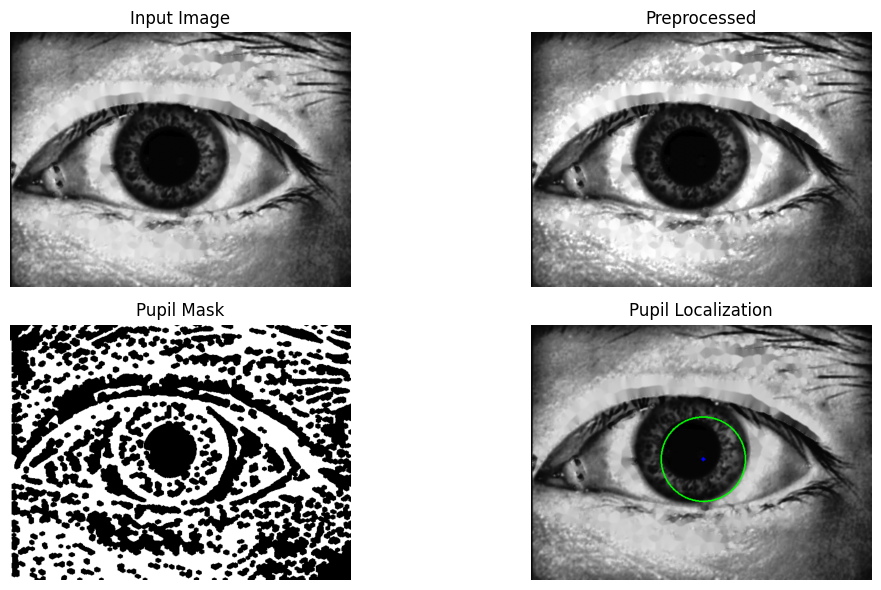

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_gray):
    # Histogram Equalization for better contrast
    return cv2.equalizeHist(img_gray)

def threshold_and_clean(img):
    # Adaptive threshold to capture dark areas like the pupil
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 35, 7)

    # Morphological operations to clean and fill pupil
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Remove small blobs (e.g. eyelashes, noise)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph)
    sizes = stats[1:, -1]
    cleaned = np.zeros_like(morph)
    for i in range(1, num_labels):
        if sizes[i-1] >= 100:  # Keep blobs bigger than 100 pixels
            cleaned[labels == i] = 255
    return cleaned

def detect_pupil_region(binary_img, original_img):
    # Use HoughCircles to find the circular region
    circles = cv2.HoughCircles(binary_img, cv2.HOUGH_GRADIENT, dp=2, minDist=30,
                               param1=50, param2=30, minRadius=10, maxRadius=80)

    output = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :1]:  # Just draw one circle
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
            cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
    return output, circles

# Load grayscale image
img_path = "/content/image_without_specular1.jpg"  # Replace with your file path
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_pre = preprocess_image(img_gray)
pupil_mask = threshold_and_clean(img_pre)
result_img, circles = detect_pupil_region(pupil_mask, img_gray)

# Display results
titles = ["Input Image", "Preprocessed", "Pupil Mask", "Pupil Localization"]
images = [img_gray, img_pre, pupil_mask, result_img]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray' if i != 3 else None)
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


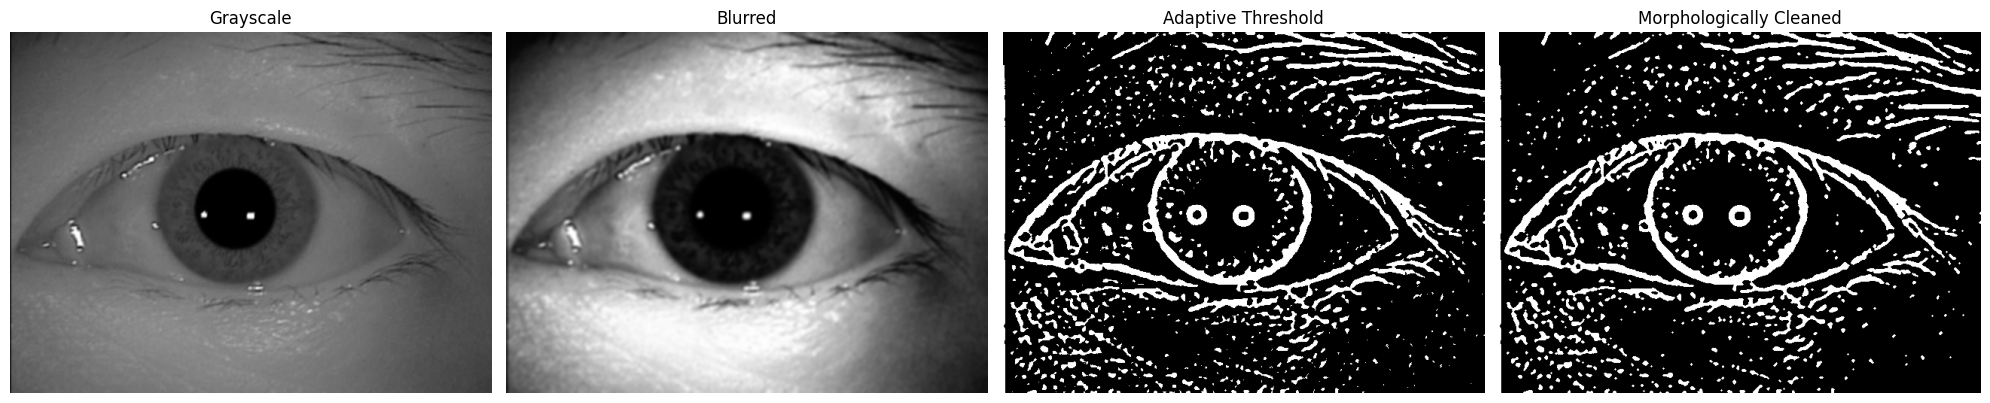

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the eye image
image_path = "/content/S6000S00.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Histogram Equalization for contrast enhancement
equalized = cv2.equalizeHist(gray)

# Step 2: Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(equalized, (7, 7), 2)

# Step 3: Adaptive Thresholding for high-contrast segmentation
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 31, 5
)

# Step 4: Morphological operations to clean up noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morphed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Show all stages
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Grayscale")
axs[1].imshow(blurred, cmap='gray')
axs[1].set_title("Blurred")
axs[2].imshow(adaptive_thresh, cmap='gray')
axs[2].set_title("Adaptive Threshold")
axs[3].imshow(morphed, cmap='gray')
axs[3].set_title("Morphologically Cleaned")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
